In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Hamiltonian Evolution with a Pulse Sequence: A 1D array example

We shall emulate using qutip a series of pulse sequences created with Pulser

In [2]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2

In [3]:
# Three-state basis:
r = qutip.basis(3,0)
g = qutip.basis(3,1)
h = qutip.basis(3,2)

In [4]:
# Basic transition operators:
I = qutip.qeye(3)

sigma_gr = r*g.dag() + g*r.dag()
rydY = -1j*r*g.dag() + 1j*g*r.dag()
rydZ = r*r.dag() - g*g.dag() 

sigma_hg = h*g.dag() + g*h.dag() 
excY = 1j*h*g.dag() - 1j*g*h.dag()
excZ = -h*h.dag() + g*g.dag() 

sigma_rr = r*r.dag()
sigma_gg = g*g.dag()
sigma_hh = h*h.dag()

In [5]:
rydY

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]]

We use a simple 1D chain of atoms

In [6]:
# Atom Register
L = 4
reg = Register.rectangle(1, L, spacing=4.9,prefix='q')
#reg.draw()  

In [7]:
#Define Device 
device = Chadoq2(reg) 

In [8]:
#Define sequence and Set channels
seq = Sequence(device)
seq.declare_channel('local', 'raman_local')
seq.declare_channel('global', 'rydberg_global')

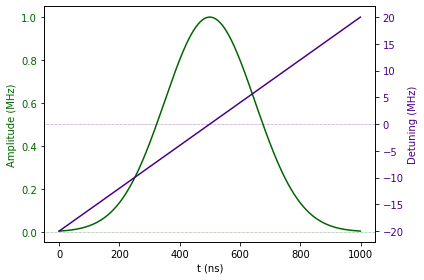

In [9]:
#Create waveforms and pulse
from pulser.waveforms import RampWaveform, GaussianWaveform

duration = 1000
amp_wf = GaussianWaveform(duration, 1, 150)   # Duration: 1000 ns, Max Amp: 1 MHz, Stdev: 150 ns
detuning_wf = RampWaveform(duration, -20, 20)  # Duration: 1000ns, linear sweep from -20 to 20 MHz

complex_pulse = Pulse(amp_wf, detuning_wf, phase=20)
complex_pulse.draw()

In [10]:
seq.target('q3','local')
seq.add(complex_pulse, 'local')
seq.add(complex_pulse, 'global')

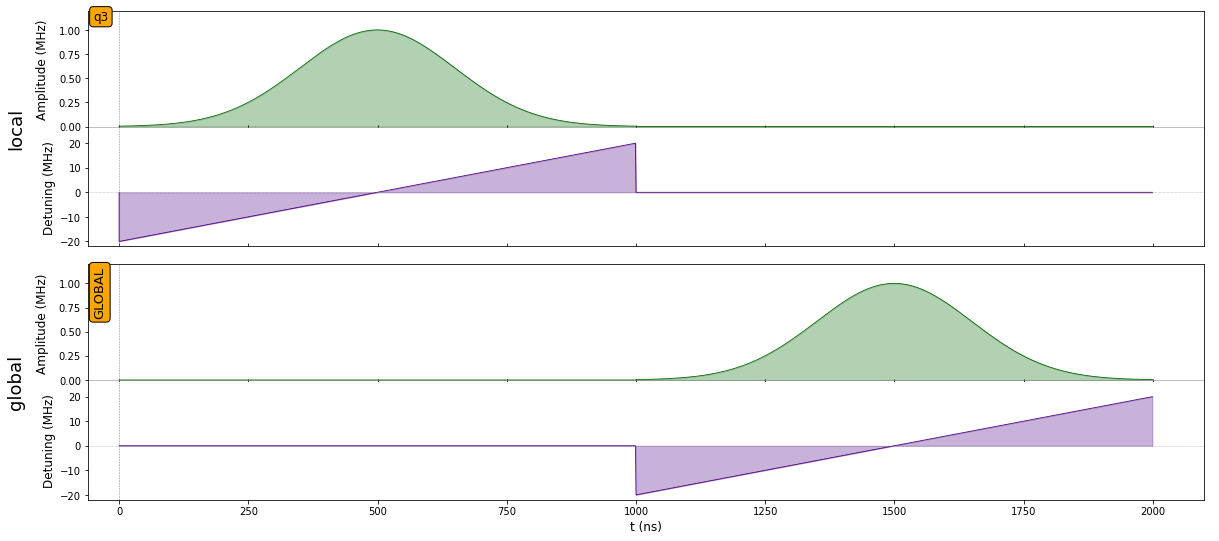

In [11]:
seq.draw()

Now that we have the pulse sequence, we emulate the evolution of the atom array using Qutip

In [12]:
#Define Operators

def local_operator(qubit_id,operator):
    """
    Returns a local gate at a qubit
    """
    temp = [qutip.qeye(3) for _ in range(L)]
    pos =  reg._ids.index(qubit_id)
    temp[pos] = operator
    return qutip.tensor(temp)

def two_body_operator(qubit_id1, qubit_id2, operator):
    """
    Returns a local operator acting on specific positions
    Parameters:
        qubit_id1, qubit_id2: keys of the atoms in which the operator acts
        operator: Qobj for the operator
    """
    if qubit_id1 == qubit_id2:
        raise ValueError("Same Atom ID given for a Two-body operator")

    temp = [qutip.qeye(3) for _ in range(L)]
    pos1 =  reg._ids.index(qubit_id1)
    pos2 =  reg._ids.index(qubit_id2)
    temp[pos1] = operator
    temp[pos2] = operator
    
    return qutip.tensor(temp)

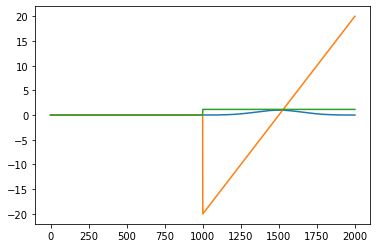

In [13]:
#Extract pulse samples from global channel

total_duration = max([seq._last(ch).tf for ch in seq._schedule])
times = np.arange(total_duration)

global_amp = np.zeros(total_duration)
global_det = np.zeros(total_duration)
global_phase = np.zeros(total_duration)

for block in seq._schedule['global']:
    if type(block.type) == Pulse:
        global_amp[block.ti:block.tf] = block.type.amplitude.samples
        global_det[block.ti:block.tf] = block.type.detuning.samples
        global_phase[block.ti:block.tf] = block.type.phase

plt.plot(times,global_amp)
plt.plot(times,global_det)
plt.plot(times,global_phase)


In [14]:
#times = np.arange(total_duration,dtype=np.double)

local_samples = {}
for qubit in reg.qubits:
    local_samples[qubit] = {'amp':np.zeros(total_duration), 
                            'det':np.zeros(total_duration), 
                            'phase':np.zeros(total_duration)} 

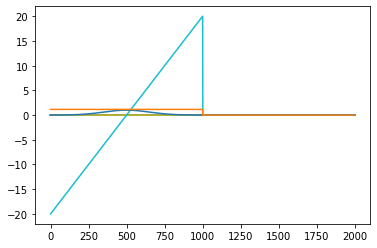

In [15]:
# Extract Pulse samples for local channel
for qubit in local_samples:
    for block in seq._schedule['local']:
        if type(block.type) == Pulse and qubit in block.targets:
            local_samples[qubit]['amp'][block.ti:block.tf] = block.type.amplitude.samples
            local_samples[qubit]['det'][block.ti:block.tf] = block.type.detuning.samples
            local_samples[qubit]['phase'][block.ti:block.tf] = block.type.phase

for qubit in local_samples:
    plt.plot(times,local_samples[qubit]['det'])
    plt.plot(times,local_samples[qubit]['amp'])
    plt.plot(times,local_samples[qubit]['phase'])

Now that we have the samples as arrays, we construct the Hamiltonian objects using 

In [16]:
# Callable coefficients
def xterm(t,args): return amplitude[int(t)]*np.cos(phase[int(t)])
def yterm(t,args): return -amplitude[int(t)]*np.sin(phase[int(t)])
def zterm(t,args): return detuning[int(t)]

In [17]:
#Components for the Hamiltonian:

#Van der Waals Interaction Terms
VdW = 0
for qubit1,qubit2 in itertools.combinations(reg._ids,r=2):
    R = np.sqrt(np.sum((reg.qubits[qubit1]-reg.qubits[qubit2])**2 ) )
    VdW += (1e5/R**6)*two_body_operator(qubit1,qubit2,sigma_rr)

#Rydberg(Global) terms
global_X = 0
global_N = 0
for qubit in reg._ids:
    global_X += local_operator(qubit,sigma_gr) #global rotation in the Ground-Rydberg basis
    global_N += local_operator(qubit,sigma_rr)

In [18]:
#Build Hamiltonian

# Build Hamiltonian as QobjEvo, using the register's coordinates
H = qutip.QobjEvo( [VdW] ) # Time independent

# Add Global X and N terms with coefficients taken from 'global' channel
H += qutip.QobjEvo( [global_N, np.array(global_det)] , tlist=times  )
H += qutip.QobjEvo( [global_X, np.array(global_amp)] , tlist=times  )

# Add Local terms taken from 'local' channel 
for qubit in reg.qubits:
    # Update Coefficient lists:
    amplitude = local_samples[qubit]['amp']
    detuning = local_samples[qubit]['det']
    phase = local_samples[qubit]['phase']
    # Add local terms to Hamiltonian
    H+=qutip.QobjEvo([[local_operator(qubit, sigma_gr), xterm],[local_operator(qubit, rydY), yterm],[local_operator(qubit, rydZ), zterm]], tlist=times)
    H+=qutip.QobjEvo([[local_operator(qubit, sigma_hg), xterm],[local_operator(qubit, excY), yterm],[local_operator(qubit, excZ), zterm]], tlist=times)


We put our functions to work on by evolving the hamiltonian

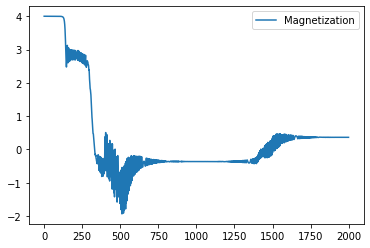

In [19]:
#Evolution using Qutip
initial = qutip.tensor([qutip.basis(3,0) for _ in range(L)])

# Add magnetization (in Rydberg basis) as observable
magnetization = 0
for qubit in reg.qubits:
    magnetization += local_operator(qubit,rydZ)

result = qutip.sesolve(H, initial, times, [magnetization]) # Without observables, we get the output state
data = result.expect[0]

plt.plot(times,data,label=f"Magnetization")
plt.legend()